프로젝트: ResNet Ablation Study

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ws_colab/

/content/drive/MyDrive/ws_colab


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()


In [ ]:
print(tf.__version__)
print(tfds.__version__)
print(np.__version__)

2.8.0
4.0.1
1.21.5


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
# tf.config.list_physical_devices('GPU')
# device_lib.list_local_devices()

# 데이터 준비


In [ ]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    data_dir = '../dataset/tf_dataset/', 
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
# tf.config.list_physical_devices('GPU')

# 정규화 함수

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 1) ResNet 기본 블록 구성하기


![GC-1-P-table1.max-800x600.png](attachment:GC-1-P-table1.max-800x600.png)

In [ ]:
# ResNet-34
def build_resnet_block_34(input_layer,
                    num_cnn=3, 
                    channel=64,
                    strides = 1,
                    block_num=1,
                    plain=False
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        if block_num == 0 and cnn_num == 0:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same',
                                               name=f'stage{block_num+2}_{cnn_num+1}_0_pooling')(x)

        shortcut_ = x
        if cnn_num == 0:
            x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = strides, activation='relu', 
                                    kernel_initializer='he_normal', padding='same', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        else:
            x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                    kernel_initializer='he_normal', padding='same', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_1_bn1')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_2_activation1')(x)
        
        x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='same', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_conv2'
                               )(x)
        if strides == 1:
            x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
            if not plain:
                x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add1')([x, shortcut_]) 
        else:
            if cnn_num == 0:
                shortcut_ = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = strides, activation='relu', 
                                kernel_initializer='he_normal', padding='valid', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_short'
                               )(shortcut_)
                x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
                shortcut_ = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn4')(shortcut_)
                if not plain:
                    x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add2')([x, shortcut_]) 
            else:
                x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
                if not plain:
                    x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add1')([x, shortcut_])                 
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_6_activation2')(x)
    return x


In [ ]:
# ResNet-50
def build_resnet_block_50(input_layer,
                    num_cnn=3, 
                    channel=64,
                    strides = 1,
                    block_num=1,
                    plain=False
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        if block_num == 0 and cnn_num == 0:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same',
                                               name=f'stage{block_num+2}_{cnn_num+1}_0_pooling')(x)

        shortcut_ = x
        if cnn_num == 0:
            x = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = strides, activation='relu', 
                                    kernel_initializer='he_normal', padding='valid', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        else:
            x = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = 1, activation='relu', 
                                    kernel_initializer='he_normal', padding='valid', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_1_bn1')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_2_activation1')(x)
        
        x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='same', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_conv2'
                               )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_5_activation2')(x)
        
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='valid', 
                                name=f'stage{block_num+2}_{cnn_num+1}_6_conv3'
                               )(x)

        if cnn_num == 0:
            shortcut_ = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides = strides, activation='relu', 
                            kernel_initializer='he_normal', padding='valid', 
                            name=f'stage{block_num+2}_{cnn_num+1}_6_conv_'
                           )(shortcut_)
            shortcut_ = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_7_bn_')(shortcut_)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_7_bn3')(x)
        if not plain:
            x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_8_add')([x, shortcut_])                 
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_9_activation3')(x)
    return x


In [ ]:
# ResNet 모델 자체를 생성
# default : ResNet-34
def build_resnet(input_shape=(32, 32, 3),
                 num_cnn_list=[3, 4, 6, 3],
                 channel_list=[64, 128, 256, 512],
                 strides_list = [1, 2, 2, 2],
                 num_classes=10, 
                 is_50=False,
                 plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    # input layer
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer
    
    # 초기 블럭, conv1, max pool
    block_num = 0
    output = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), activation='relu', 
                            kernel_initializer='he_normal', padding='same', 
                            name=f'stage{block_num}_0_0_conv64')(output)
    output = keras.layers.BatchNormalization(name=f'stage{block_num}_0_1_batchNo')(output)
    output = keras.layers.Activation(activation = 'relu', 
                                     name=f'stage{block_num}_0_2_activation')(output)
    
    # 블록을 생성
    if is_50:
        for i, (num_cnn, channel, strides) in enumerate(zip(num_cnn_list, channel_list, strides_list)):
            output = build_resnet_block_50(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                strides = strides,
                block_num=i,
                plain=plain
            )
    else:
        for i, (num_cnn, channel, strides) in enumerate(zip(num_cnn_list, channel_list, strides_list)):
            output = build_resnet_block_34(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                strides = strides,
                block_num=i,
                plain=plain
            )
        
    output = keras.layers.GlobalAveragePooling2D(name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model



# 2) ResNet-34, ResNet-50 Complete Model

In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_8[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

# 3) 일반 네트워크(plain network) 만들기

In [ ]:
resnet_34_p = build_resnet(input_shape=(32, 32,3), is_50=False, plain=True)
resnet_34_p.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage0_0_0_conv64 (Conv2D)  (None, 16, 16, 64)        9472      
                                                                 
 stage0_0_1_batchNo (BatchNo  (None, 16, 16, 64)       256       
 rmalization)                                                    
                                                                 
 stage0_0_2_activation (Acti  (None, 16, 16, 64)       0         
 vation)                                                         
                                                                 
 stage2_1_0_pooling (MaxPool  (None, 8, 8, 64)         0         
 ing2D)                                                          
                                                           

In [ ]:
resnet_50_p = build_resnet(input_shape=(32, 32,3), is_50=True, plain=True)
resnet_50_p.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 stage0_0_0_conv64 (Conv2D)  (None, 16, 16, 64)        9472      
                                                                 
 stage0_0_1_batchNo (BatchNo  (None, 16, 16, 64)       256       
 rmalization)                                                    
                                                                 
 stage0_0_2_activation (Acti  (None, 16, 16, 64)       0         
 vation)                                                         
                                                                 
 stage2_1_0_pooling (MaxPool  (None, 8, 8, 64)         0         
 ing2D)                                                          
                                                           

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [ ]:
BATCH_SIZE = 256

EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    data_dir = '../dataset/tf_dataset/', 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
resnet_34_p.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_p= resnet_34_p.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 29s 91ms/step - loss: 2.6183 - accuracy: 0.1188 - val_loss: 2.3026 - val_accuracy: 0.1012
Epoch 2/15
195/195 [==============================] - 17s 88ms/step - loss: 2.5127 - accuracy: 0.1230 - val_loss: 2.3028 - val_accuracy: 0.1027
Epoch 3/15
195/195 [==============================] - 15s 76ms/step - loss: 2.4424 - accuracy: 0.1243 - val_loss: 2.3203 - val_accuracy: 0.1111
Epoch 4/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3982 - accuracy: 0.1261 - val_loss: 2.3914 - val_accuracy: 0.1146
Epoch 5/15
195/195 [==============================] - 15s 76ms/step - loss: 2.3742 - accuracy: 0.1243 - val_loss: 2.4249 - val_accuracy: 0.1232
Epoch 6/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3518 - accuracy: 0.1243 - val_loss: 2.3743 - val_accuracy: 0.1174
Epoch 7/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3354 - accuracy: 0.1234 - val_loss: 2.3944 - val_accuracy: 0.1115
Epo

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34= resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 82ms/step - loss: 3.2892 - accuracy: 0.1090 - val_loss: 2.3028 - val_accuracy: 0.0989
Epoch 2/15
195/195 [==============================] - 15s 79ms/step - loss: 2.9015 - accuracy: 0.1421 - val_loss: 2.3081 - val_accuracy: 0.1023
Epoch 3/15
195/195 [==============================] - 18s 90ms/step - loss: 2.7122 - accuracy: 0.1450 - val_loss: 2.4114 - val_accuracy: 0.1314
Epoch 4/15
195/195 [==============================] - 15s 79ms/step - loss: 2.5820 - accuracy: 0.1516 - val_loss: 2.4985 - val_accuracy: 0.1452
Epoch 5/15
195/195 [==============================] - 15s 79ms/step - loss: 2.5027 - accuracy: 0.1531 - val_loss: 2.4868 - val_accuracy: 0.1491
Epoch 6/15
195/195 [==============================] - 15s 79ms/step - loss: 2.4346 - accuracy: 0.1597 - val_loss: 2.4673 - val_accuracy: 0.1645
Epoch 7/15
195/195 [==============================] - 15s 79ms/step - loss: 2.3760 - accuracy: 0.1656 - val_loss: 2.4856 - val_accuracy: 0.1793
Epo

In [ ]:
resnet_50_p.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_p= resnet_50_p.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 28s 89ms/step - loss: 2.6790 - accuracy: 0.1195 - val_loss: 2.3030 - val_accuracy: 0.0968
Epoch 2/15
195/195 [==============================] - 17s 85ms/step - loss: 2.5886 - accuracy: 0.1186 - val_loss: 2.3033 - val_accuracy: 0.1018
Epoch 3/15
195/195 [==============================] - 17s 85ms/step - loss: 2.5402 - accuracy: 0.1236 - val_loss: 2.3146 - val_accuracy: 0.1021
Epoch 4/15
195/195 [==============================] - 17s 86ms/step - loss: 2.4979 - accuracy: 0.1258 - val_loss: 2.4565 - val_accuracy: 0.1150
Epoch 5/15
195/195 [==============================] - 19s 96ms/step - loss: 2.4681 - accuracy: 0.1254 - val_loss: 2.5140 - val_accuracy: 0.1187
Epoch 6/15
195/195 [==============================] - 17s 85ms/step - loss: 2.4564 - accuracy: 0.1255 - val_loss: 2.4836 - val_accuracy: 0.1182
Epoch 7/15
195/195 [==============================] - 17s 85ms/step - loss: 2.4378 - accuracy: 0.1248 - val_loss: 2.6324 - val_accuracy: 0.1242
Epo

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50= resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 30s 99ms/step - loss: 3.5038 - accuracy: 0.1249 - val_loss: 2.3031 - val_accuracy: 0.0972
Epoch 2/15
195/195 [==============================] - 18s 94ms/step - loss: 3.3329 - accuracy: 0.1326 - val_loss: 2.3038 - val_accuracy: 0.0986
Epoch 3/15
195/195 [==============================] - 18s 95ms/step - loss: 3.2002 - accuracy: 0.1328 - val_loss: 2.4586 - val_accuracy: 0.1239
Epoch 4/15
195/195 [==============================] - 19s 95ms/step - loss: 3.0982 - accuracy: 0.1341 - val_loss: 2.8587 - val_accuracy: 0.1297
Epoch 5/15
195/195 [==============================] - 18s 95ms/step - loss: 3.0118 - accuracy: 0.1329 - val_loss: 3.0125 - val_accuracy: 0.1287
Epoch 6/15
195/195 [==============================] - 18s 95ms/step - loss: 2.9414 - accuracy: 0.1344 - val_loss: 2.9319 - val_accuracy: 0.1363
Epoch 7/15
195/195 [==============================] - 19s 95ms/step - loss: 2.8871 - accuracy: 0.1330 - val_loss: 2.8678 - val_accuracy: 0.1366
Epo

# 시각화

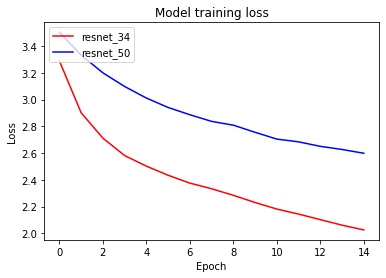

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


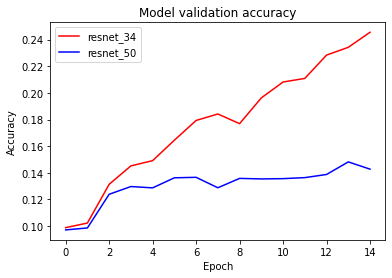

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

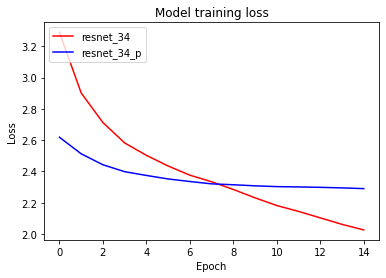

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_p'], loc='upper left')
plt.show()


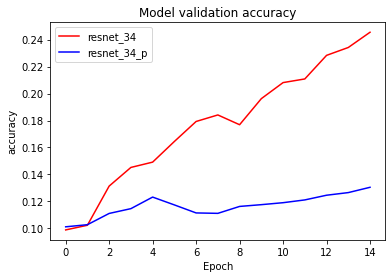

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_p'], loc='upper left')
plt.show()


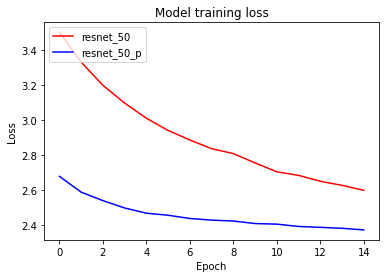

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_p'], loc='upper left')
plt.show()


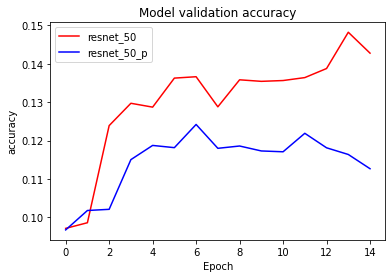

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_p'], loc='upper left')
plt.show()


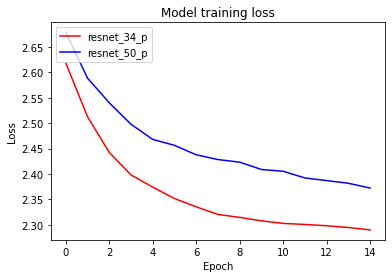

In [ ]:
plt.plot(history_34_p.history['loss'], 'r')
plt.plot(history_50_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34_p', 'resnet_50_p'], loc='upper left')
plt.show()


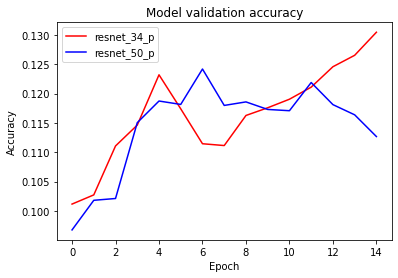

In [ ]:
plt.plot(history_34_p.history['val_accuracy'], 'r')
plt.plot(history_50_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34_p', 'resnet_50_p'], loc='upper left')
plt.show()

In [ ]:
BATCH_SIZE = 256
EPOCH = 50

In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_5[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()



Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_6[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34= resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 82ms/step - loss: 3.3159 - accuracy: 0.1190 - val_loss: 2.3031 - val_accuracy: 0.0944
Epoch 2/50
195/195 [==============================] - 15s 79ms/step - loss: 2.9169 - accuracy: 0.1348 - val_loss: 2.3084 - val_accuracy: 0.0964
Epoch 3/50
195/195 [==============================] - 15s 79ms/step - loss: 2.7111 - accuracy: 0.1412 - val_loss: 2.4200 - val_accuracy: 0.1297
Epoch 4/50
195/195 [==============================] - 15s 79ms/step - loss: 2.5794 - accuracy: 0.1449 - val_loss: 2.5640 - val_accuracy: 0.1418
Epoch 5/50
195/195 [==============================] - 18s 91ms/step - loss: 2.4859 - accuracy: 0.1469 - val_loss: 2.5415 - val_accuracy: 0.1481
Epoch 6/50
195/195 [==============================] - 18s 90ms/step - loss: 2.4114 - accuracy: 0.1572 - val_loss: 2.4752 - val_accuracy: 0.1621
Epoch 7/50
195/195 [==============================] - 15s 78ms/step - loss: 2.3694 - accuracy: 0.1597 - val_loss: 2.4149 - val_accuracy: 0.1604
Epo

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50= resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 31s 99ms/step - loss: 3.5122 - accuracy: 0.1219 - val_loss: 2.3029 - val_accuracy: 0.1003
Epoch 2/50
195/195 [==============================] - 18s 94ms/step - loss: 3.3143 - accuracy: 0.1295 - val_loss: 2.3033 - val_accuracy: 0.1029
Epoch 3/50
195/195 [==============================] - 19s 95ms/step - loss: 3.2022 - accuracy: 0.1311 - val_loss: 2.5365 - val_accuracy: 0.1252
Epoch 4/50
195/195 [==============================] - 19s 95ms/step - loss: 3.1092 - accuracy: 0.1295 - val_loss: 2.9602 - val_accuracy: 0.1226
Epoch 5/50
195/195 [==============================] - 18s 95ms/step - loss: 3.0157 - accuracy: 0.1266 - val_loss: 2.9646 - val_accuracy: 0.1301
Epoch 6/50
195/195 [==============================] - 19s 95ms/step - loss: 2.9667 - accuracy: 0.1327 - val_loss: 3.3008 - val_accuracy: 0.1403
Epoch 7/50
195/195 [==============================] - 19s 95ms/step - loss: 2.8961 - accuracy: 0.1322 - val_loss: 2.8900 - val_accuracy: 0.1299
Epo

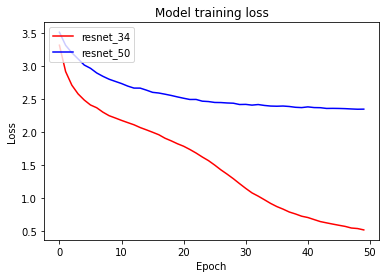

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


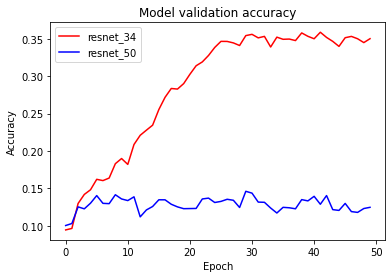

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

프로젝트: ResNet Ablation Study

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/ws_colab/

/content/drive/MyDrive/ws_colab


In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

import urllib3
urllib3.disable_warnings()


In [ ]:
print(tf.__version__)
print(tfds.__version__)
print(np.__version__)

2.8.0
4.0.1
1.21.5


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
# tf.config.list_physical_devices('GPU')
# device_lib.list_local_devices()

# 데이터 준비


In [ ]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    data_dir = '../dataset/tf_dataset/', 
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [ ]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [ ]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
# tf.config.list_physical_devices('GPU')

# 정규화 함수

In [ ]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 1) ResNet 기본 블록 구성하기


![GC-1-P-table1.max-800x600.png](attachment:GC-1-P-table1.max-800x600.png)

In [ ]:
# ResNet-34
def build_resnet_block_34(input_layer,
                    num_cnn=3, 
                    channel=64,
                    strides = 1,
                    block_num=1,
                    plain=False
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        if block_num == 0 and cnn_num == 0:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same',
                                               name=f'stage{block_num+2}_{cnn_num+1}_0_pooling')(x)

        shortcut_ = x
        if cnn_num == 0:
            x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = strides, activation='relu', 
                                    kernel_initializer='he_normal', padding='same', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        else:
            x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                    kernel_initializer='he_normal', padding='same', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_1_bn1')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_2_activation1')(x)
        
        x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='same', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_conv2'
                               )(x)
        if strides == 1:
            x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
            if not plain:
                x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add1')([x, shortcut_]) 
        else:
            if cnn_num == 0:
                shortcut_ = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = strides, activation='relu', 
                                kernel_initializer='he_normal', padding='valid', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_short'
                               )(shortcut_)
                x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
                shortcut_ = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn4')(shortcut_)
                if not plain:
                    x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add2')([x, shortcut_]) 
            else:
                x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
                if not plain:
                    x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_5_add1')([x, shortcut_])                 
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_6_activation2')(x)
    return x


In [ ]:
# ResNet-50
def build_resnet_block_50(input_layer,
                    num_cnn=3, 
                    channel=64,
                    strides = 1,
                    block_num=1,
                    plain=False
                   ):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        if block_num == 0 and cnn_num == 0:
            x = keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same',
                                               name=f'stage{block_num+2}_{cnn_num+1}_0_pooling')(x)

        shortcut_ = x
        if cnn_num == 0:
            x = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = strides, activation='relu', 
                                    kernel_initializer='he_normal', padding='valid', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        else:
            x = keras.layers.Conv2D(filters=channel, kernel_size=1, strides = 1, activation='relu', 
                                    kernel_initializer='he_normal', padding='valid', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_0_conv1'
                                   )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_1_bn1')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_2_activation1')(x)
        
        x = keras.layers.Conv2D(filters=channel, kernel_size=3, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='same', 
                                name=f'stage{block_num+2}_{cnn_num+1}_3_conv2'
                               )(x)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_4_bn2')(x)
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_5_activation2')(x)
        
        x = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides = 1, activation='relu', 
                                kernel_initializer='he_normal', padding='valid', 
                                name=f'stage{block_num+2}_{cnn_num+1}_6_conv3'
                               )(x)

        if cnn_num == 0:
            shortcut_ = keras.layers.Conv2D(filters=channel*4, kernel_size=1, strides = strides, activation='relu', 
                            kernel_initializer='he_normal', padding='valid', 
                            name=f'stage{block_num+2}_{cnn_num+1}_6_conv_'
                           )(shortcut_)
            shortcut_ = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_7_bn_')(shortcut_)
        x = keras.layers.BatchNormalization(name=f'stage{block_num+2}_{cnn_num+1}_7_bn3')(x)
        if not plain:
            x = keras.layers.Add(name=f'stage{block_num+2}_{cnn_num+1}_8_add')([x, shortcut_])                 
        x = keras.layers.Activation(activation = 'relu', 
                                    name=f'stage{block_num+2}_{cnn_num+1}_9_activation3')(x)
    return x


In [ ]:
# ResNet 모델 자체를 생성
# default : ResNet-34
def build_resnet(input_shape=(32, 32, 3),
                 num_cnn_list=[3, 4, 6, 3],
                 channel_list=[64, 128, 256, 512],
                 strides_list = [1, 2, 2, 2],
                 num_classes=10, 
                 is_50=False,
                 plain=False):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    # input layer
    input_layer = keras.layers.Input(shape=input_shape)  
    output = input_layer
    
    # 초기 블럭, conv1, max pool
    block_num = 0
    output = keras.layers.Conv2D(filters = 64, kernel_size = (7, 7), strides = (2, 2), activation='relu', 
                            kernel_initializer='he_normal', padding='same', 
                            name=f'stage{block_num}_0_0_conv64')(output)
    output = keras.layers.BatchNormalization(name=f'stage{block_num}_0_1_batchNo')(output)
    output = keras.layers.Activation(activation = 'relu', 
                                     name=f'stage{block_num}_0_2_activation')(output)
    
    # 블록을 생성
    if is_50:
        for i, (num_cnn, channel, strides) in enumerate(zip(num_cnn_list, channel_list, strides_list)):
            output = build_resnet_block_50(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                strides = strides,
                block_num=i,
                plain=plain
            )
    else:
        for i, (num_cnn, channel, strides) in enumerate(zip(num_cnn_list, channel_list, strides_list)):
            output = build_resnet_block_34(
                output,
                num_cnn=num_cnn, 
                channel=channel,
                strides = strides,
                block_num=i,
                plain=plain
            )
        
    output = keras.layers.GlobalAveragePooling2D(name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model



# 2) ResNet-34, ResNet-50 Complete Model

In [ ]:
resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_7[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

In [ ]:
resnet_50 = build_resnet(input_shape=(32, 32,3), is_50=True)
resnet_50.summary()



Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 stage0_0_0_conv64 (Conv2D)     (None, 16, 16, 64)   9472        ['input_8[0][0]']                
                                                                                                  
 stage0_0_1_batchNo (BatchNorma  (None, 16, 16, 64)  256         ['stage0_0_0_conv64[0][0]']      
 lization)                                                                                        
                                                                                                  
 stage0_0_2_activation (Activat  (None, 16, 16, 64)  0           ['stage0_0_1_batchNo[0][0]'

# 3) 일반 네트워크(plain network) 만들기

In [ ]:
resnet_34_p = build_resnet(input_shape=(32, 32,3), is_50=False, plain=True)
resnet_34_p.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 stage0_0_0_conv64 (Conv2D)  (None, 16, 16, 64)        9472      
                                                                 
 stage0_0_1_batchNo (BatchNo  (None, 16, 16, 64)       256       
 rmalization)                                                    
                                                                 
 stage0_0_2_activation (Acti  (None, 16, 16, 64)       0         
 vation)                                                         
                                                                 
 stage2_1_0_pooling (MaxPool  (None, 8, 8, 64)         0         
 ing2D)                                                          
                                                           

In [ ]:
resnet_50_p = build_resnet(input_shape=(32, 32,3), is_50=True, plain=True)
resnet_50_p.summary()


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 stage0_0_0_conv64 (Conv2D)  (None, 16, 16, 64)        9472      
                                                                 
 stage0_0_1_batchNo (BatchNo  (None, 16, 16, 64)       256       
 rmalization)                                                    
                                                                 
 stage0_0_2_activation (Acti  (None, 16, 16, 64)       0         
 vation)                                                         
                                                                 
 stage2_1_0_pooling (MaxPool  (None, 8, 8, 64)         0         
 ing2D)                                                          
                                                           

# 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

In [ ]:
BATCH_SIZE = 256

EPOCH = 15

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    data_dir = '../dataset/tf_dataset/', 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
resnet_34_p.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_p= resnet_34_p.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 29s 91ms/step - loss: 2.6183 - accuracy: 0.1188 - val_loss: 2.3026 - val_accuracy: 0.1012
Epoch 2/15
195/195 [==============================] - 17s 88ms/step - loss: 2.5127 - accuracy: 0.1230 - val_loss: 2.3028 - val_accuracy: 0.1027
Epoch 3/15
195/195 [==============================] - 15s 76ms/step - loss: 2.4424 - accuracy: 0.1243 - val_loss: 2.3203 - val_accuracy: 0.1111
Epoch 4/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3982 - accuracy: 0.1261 - val_loss: 2.3914 - val_accuracy: 0.1146
Epoch 5/15
195/195 [==============================] - 15s 76ms/step - loss: 2.3742 - accuracy: 0.1243 - val_loss: 2.4249 - val_accuracy: 0.1232
Epoch 6/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3518 - accuracy: 0.1243 - val_loss: 2.3743 - val_accuracy: 0.1174
Epoch 7/15
195/195 [==============================] - 15s 77ms/step - loss: 2.3354 - accuracy: 0.1234 - val_loss: 2.3944 - val_accuracy: 0.1115
Epo

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34= resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 82ms/step - loss: 3.2892 - accuracy: 0.1090 - val_loss: 2.3028 - val_accuracy: 0.0989
Epoch 2/15
195/195 [==============================] - 15s 79ms/step - loss: 2.9015 - accuracy: 0.1421 - val_loss: 2.3081 - val_accuracy: 0.1023
Epoch 3/15
195/195 [==============================] - 18s 90ms/step - loss: 2.7122 - accuracy: 0.1450 - val_loss: 2.4114 - val_accuracy: 0.1314
Epoch 4/15
195/195 [==============================] - 15s 79ms/step - loss: 2.5820 - accuracy: 0.1516 - val_loss: 2.4985 - val_accuracy: 0.1452
Epoch 5/15
195/195 [==============================] - 15s 79ms/step - loss: 2.5027 - accuracy: 0.1531 - val_loss: 2.4868 - val_accuracy: 0.1491
Epoch 6/15
195/195 [==============================] - 15s 79ms/step - loss: 2.4346 - accuracy: 0.1597 - val_loss: 2.4673 - val_accuracy: 0.1645
Epoch 7/15
195/195 [==============================] - 15s 79ms/step - loss: 2.3760 - accuracy: 0.1656 - val_loss: 2.4856 - val_accuracy: 0.1793
Epo

In [ ]:
resnet_50_p.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_p= resnet_50_p.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 28s 89ms/step - loss: 2.6790 - accuracy: 0.1195 - val_loss: 2.3030 - val_accuracy: 0.0968
Epoch 2/15
195/195 [==============================] - 17s 85ms/step - loss: 2.5886 - accuracy: 0.1186 - val_loss: 2.3033 - val_accuracy: 0.1018
Epoch 3/15
195/195 [==============================] - 17s 85ms/step - loss: 2.5402 - accuracy: 0.1236 - val_loss: 2.3146 - val_accuracy: 0.1021
Epoch 4/15
195/195 [==============================] - 17s 86ms/step - loss: 2.4979 - accuracy: 0.1258 - val_loss: 2.4565 - val_accuracy: 0.1150
Epoch 5/15
195/195 [==============================] - 19s 96ms/step - loss: 2.4681 - accuracy: 0.1254 - val_loss: 2.5140 - val_accuracy: 0.1187
Epoch 6/15
195/195 [==============================] - 17s 85ms/step - loss: 2.4564 - accuracy: 0.1255 - val_loss: 2.4836 - val_accuracy: 0.1182
Epoch 7/15
195/195 [==============================] - 17s 85ms/step - loss: 2.4378 - accuracy: 0.1248 - val_loss: 2.6324 - val_accuracy: 0.1242
Epo

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50= resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 30s 99ms/step - loss: 3.5038 - accuracy: 0.1249 - val_loss: 2.3031 - val_accuracy: 0.0972
Epoch 2/15
195/195 [==============================] - 18s 94ms/step - loss: 3.3329 - accuracy: 0.1326 - val_loss: 2.3038 - val_accuracy: 0.0986
Epoch 3/15
195/195 [==============================] - 18s 95ms/step - loss: 3.2002 - accuracy: 0.1328 - val_loss: 2.4586 - val_accuracy: 0.1239
Epoch 4/15
195/195 [==============================] - 19s 95ms/step - loss: 3.0982 - accuracy: 0.1341 - val_loss: 2.8587 - val_accuracy: 0.1297
Epoch 5/15
195/195 [==============================] - 18s 95ms/step - loss: 3.0118 - accuracy: 0.1329 - val_loss: 3.0125 - val_accuracy: 0.1287
Epoch 6/15
195/195 [==============================] - 18s 95ms/step - loss: 2.9414 - accuracy: 0.1344 - val_loss: 2.9319 - val_accuracy: 0.1363
Epoch 7/15
195/195 [==============================] - 19s 95ms/step - loss: 2.8871 - accuracy: 0.1330 - val_loss: 2.8678 - val_accuracy: 0.1366
Epo

# 시각화

## renet_34, renet_50 비교

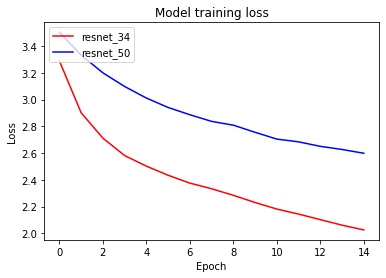

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


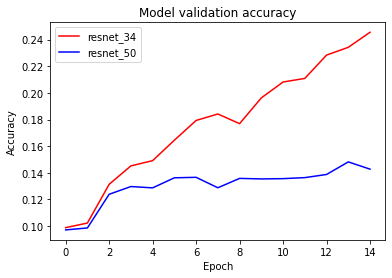

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()

## renet_34, renet_34_plain 비교

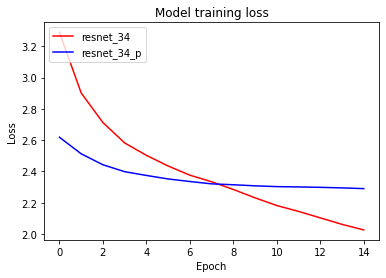

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_34_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_p'], loc='upper left')
plt.show()


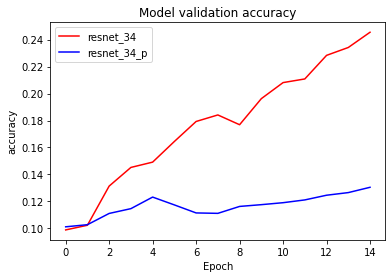

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_34_p'], loc='upper left')
plt.show()


## renet_50, renet_50_plain 비교

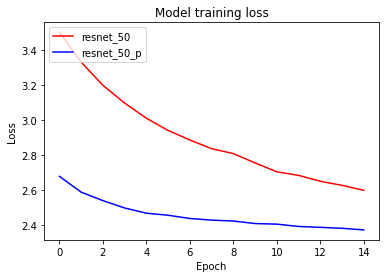

In [ ]:
plt.plot(history_50.history['loss'], 'r')
plt.plot(history_50_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_p'], loc='upper left')
plt.show()


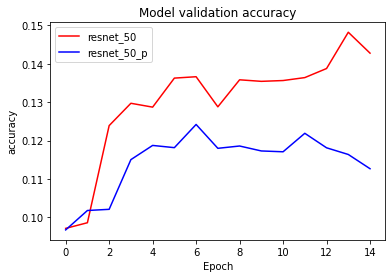

In [ ]:
plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'resnet_50_p'], loc='upper left')
plt.show()


## renet_34_plain, renet_50_plain 비교

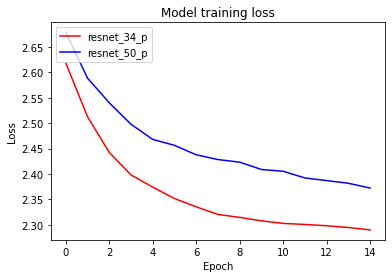

In [ ]:
plt.plot(history_34_p.history['loss'], 'r')
plt.plot(history_50_p.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34_p', 'resnet_50_p'], loc='upper left')
plt.show()


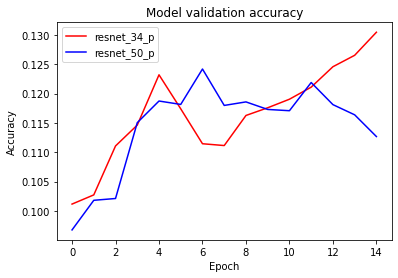

In [ ]:
plt.plot(history_34_p.history['val_accuracy'], 'r')
plt.plot(history_50_p.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34_p', 'resnet_50_p'], loc='upper left')
plt.show()

## renet_34, renet_50 (EPOCH 50) 비교

In [ ]:
BATCH_SIZE = 256
EPOCH = 50

In [ ]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34= resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 24s 82ms/step - loss: 3.3159 - accuracy: 0.1190 - val_loss: 2.3031 - val_accuracy: 0.0944
Epoch 2/50
195/195 [==============================] - 15s 79ms/step - loss: 2.9169 - accuracy: 0.1348 - val_loss: 2.3084 - val_accuracy: 0.0964
Epoch 3/50
195/195 [==============================] - 15s 79ms/step - loss: 2.7111 - accuracy: 0.1412 - val_loss: 2.4200 - val_accuracy: 0.1297
Epoch 4/50
195/195 [==============================] - 15s 79ms/step - loss: 2.5794 - accuracy: 0.1449 - val_loss: 2.5640 - val_accuracy: 0.1418
Epoch 5/50
195/195 [==============================] - 18s 91ms/step - loss: 2.4859 - accuracy: 0.1469 - val_loss: 2.5415 - val_accuracy: 0.1481
Epoch 6/50
195/195 [==============================] - 18s 90ms/step - loss: 2.4114 - accuracy: 0.1572 - val_loss: 2.4752 - val_accuracy: 0.1621
Epoch 7/50
195/195 [==============================] - 15s 78ms/step - loss: 2.3694 - accuracy: 0.1597 - val_loss: 2.4149 - val_accuracy: 0.1604
Epo

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50= resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 31s 99ms/step - loss: 3.5122 - accuracy: 0.1219 - val_loss: 2.3029 - val_accuracy: 0.1003
Epoch 2/50
195/195 [==============================] - 18s 94ms/step - loss: 3.3143 - accuracy: 0.1295 - val_loss: 2.3033 - val_accuracy: 0.1029
Epoch 3/50
195/195 [==============================] - 19s 95ms/step - loss: 3.2022 - accuracy: 0.1311 - val_loss: 2.5365 - val_accuracy: 0.1252
Epoch 4/50
195/195 [==============================] - 19s 95ms/step - loss: 3.1092 - accuracy: 0.1295 - val_loss: 2.9602 - val_accuracy: 0.1226
Epoch 5/50
195/195 [==============================] - 18s 95ms/step - loss: 3.0157 - accuracy: 0.1266 - val_loss: 2.9646 - val_accuracy: 0.1301
Epoch 6/50
195/195 [==============================] - 19s 95ms/step - loss: 2.9667 - accuracy: 0.1327 - val_loss: 3.3008 - val_accuracy: 0.1403
Epoch 7/50
195/195 [==============================] - 19s 95ms/step - loss: 2.8961 - accuracy: 0.1322 - val_loss: 2.8900 - val_accuracy: 0.1299
Epo

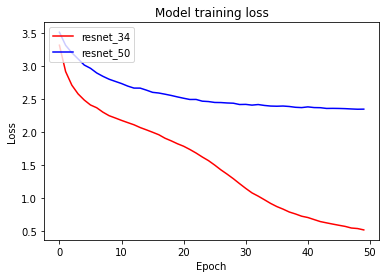

In [ ]:
plt.plot(history_34.history['loss'], 'r')
plt.plot(history_50.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()


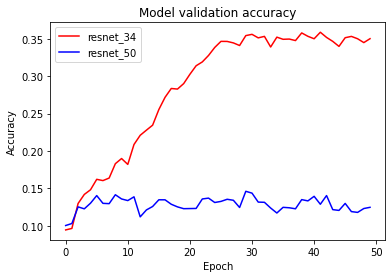

In [ ]:
plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50'], loc='upper left')
plt.show()